In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

/Users/avani/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Dataset Cleaning and Preprocessing

In [3]:
data = pd.read_excel('DATASET.xlsx', sheet_name='MergedSheet158')
data = data.drop(['CSD'], axis=1)
data.sample(3)

,Density,PLD,LCD,VSA,GSA,Void Fraction,Pore Volume,Probe1,Probe2,Probe3,Probe4,Target
2198,1.447,5.90,6.86,1229.51,849.513,0.54,0.3829,1.421457,2.082013,3.671431,7.575050,106.176491
3965,2.292,2.43,3.41,0.00,0.000,0.14,0.1704,0.494619,0.380068,0.099101,0.000987,0.942694
221,1.714,3.05,4.24,0.00,0.000,0.33,0.2606,0.953062,1.198317,1.582867,1.702624,70.476297


In [4]:
data.columns

Index(['Density', 'PLD', 'LCD', 'VSA', 'GSA ', 'Void Fraction', 'Pore Volume',
       'Probe1', 'Probe2', 'Probe3', 'Probe4', 'Target'],
      dtype='object')

In [5]:
data.shape

(4763, 12)

In [6]:
data.isna().sum() 

Density          0
PLD              0
LCD              0
VSA              0
GSA              0
Void Fraction    0
Pore Volume      0
Probe1           0
Probe2           0
Probe3           0
Probe4           0
Target           0
dtype: int64

No missing values.

# Data Analysis

In [7]:
zeros = (data == 0).sum()
print("Number of zeros in each column:")
print(zeros)

Number of zeros in each column:
Density             0
PLD                 0
LCD                 0
VSA              1899
GSA              1899
Void Fraction       1
Pore Volume         0
Probe1              0
Probe2              1
Probe3              7
Probe4             54
Target             56
dtype: int64


Many VSA and GSA values are 0. <br>
Feature selection will be done by dropping the columns or not.

In [8]:
data.describe()

,Density,PLD,LCD,VSA,GSA,Void Fraction,Pore Volume,Probe1,Probe2,Probe3,Probe4,Target
count,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000
mean,1.377532,4.816252,6.764134,758.717795,826.226905,0.423634,0.492471,1.074607,1.463564,2.181763,3.570915,67.353890
std,0.501598,2.866811,3.865055,760.699108,1079.345669,0.207494,0.398294,0.381651,0.706474,1.581898,4.360896,35.220308
min,0.127000,2.400000,2.530000,0.000000,0.000000,0.000000,0.071800,0.003441,0.000000,0.000000,0.000000,0.000000
25%,1.048000,3.190000,4.620000,0.000000,0.000000,0.260000,0.272400,0.804936,1.009594,1.272528,1.409026,41.256367
50%,1.313000,4.050000,5.570000,629.801000,428.343000,0.400000,0.388400,1.117098,1.487235,2.135482,3.117869,69.087016
75%,1.652000,5.505000,7.460000,1400.655000,1279.255000,0.590000,0.568900,1.345574,1.874815,2.902715,4.911694,93.340703
max,5.180000,71.500000,71.640000,3094.420000,6832.550000,0.970000,7.457900,4.885895,12.856261,36.215991,122.200874,202.024404


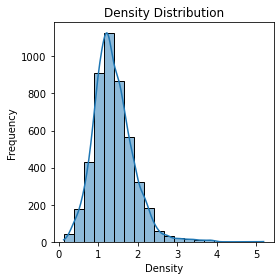

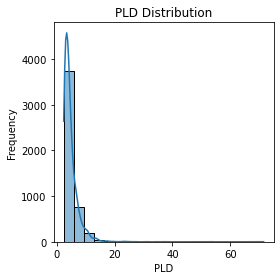

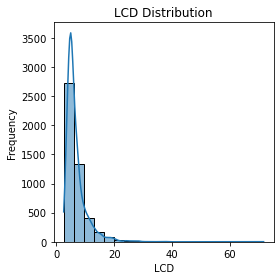

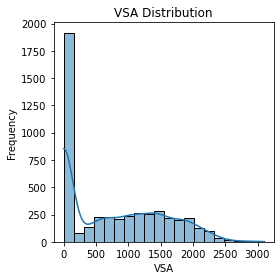

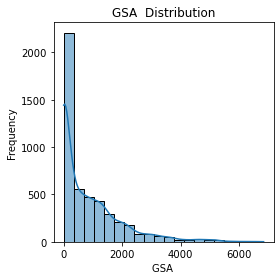

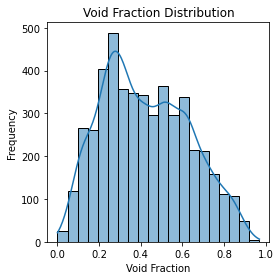

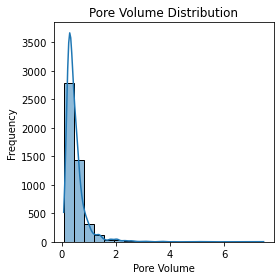

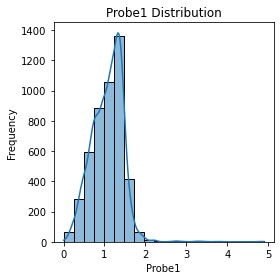

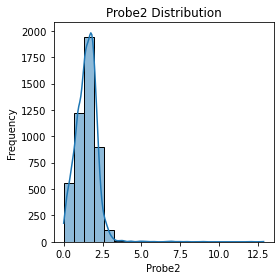

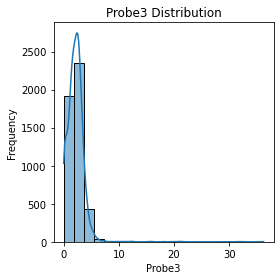

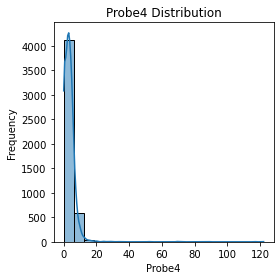

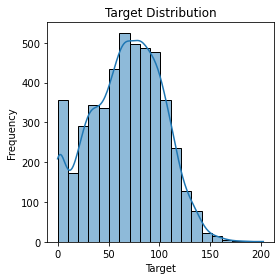

In [9]:
for feature in data.columns:
    plt.figure(figsize=(4,4))
    sns.histplot(data[feature], bins=20, kde=True)
    plt.title(f"{feature} Distribution")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

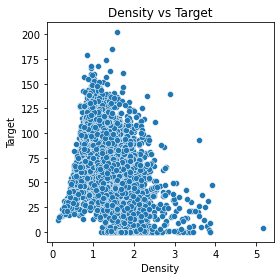

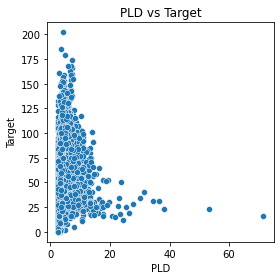

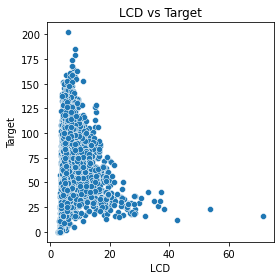

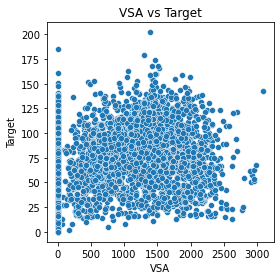

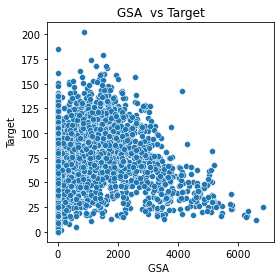

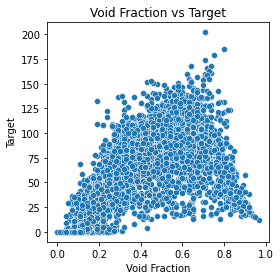

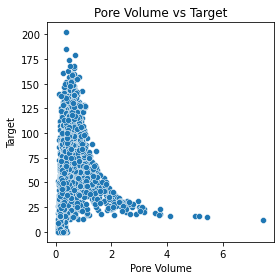

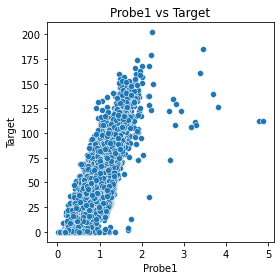

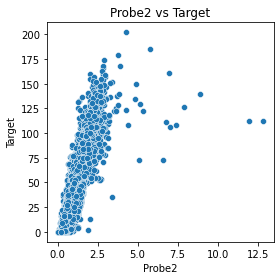

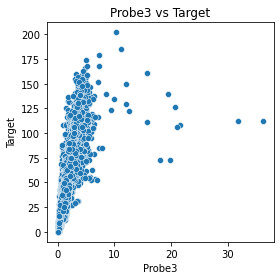

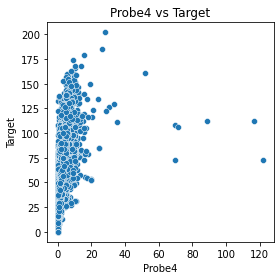

In [10]:
X_train = data.drop(['Target'], axis=1)
y_train = data['Target']
for feature in X_train.columns:
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=X_train[feature], y=y_train)
    plt.title(f"{feature} vs Target")
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.tight_layout()
    plt.show()

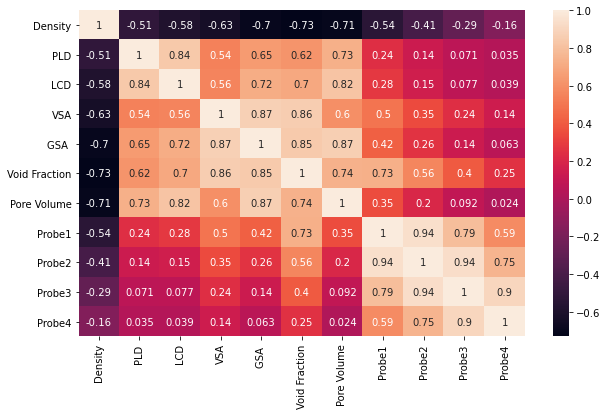

In [11]:
hmdata = data.drop(['Target'], axis=1).corr()
plt.figure(figsize=(10,6))
sns.heatmap(hmdata, annot=True)
plt.show()

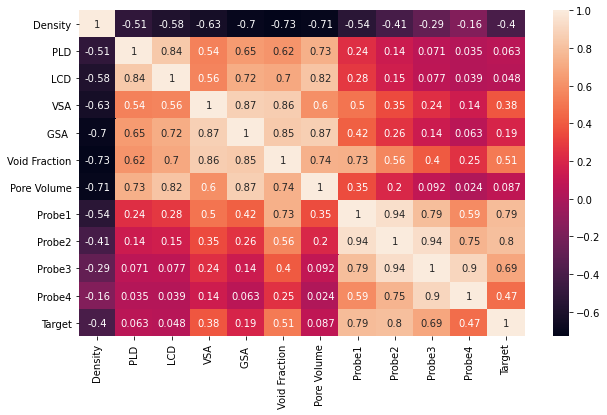

In [12]:
hmdata = data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(hmdata, annot=True)
plt.show()

Strong Positive Correlation - between Probe 1 and 2, Probe 2 and 3, Probe 3 and Probe 4. <br>
Strong Negative Correlation - between Density and Void Fraction.

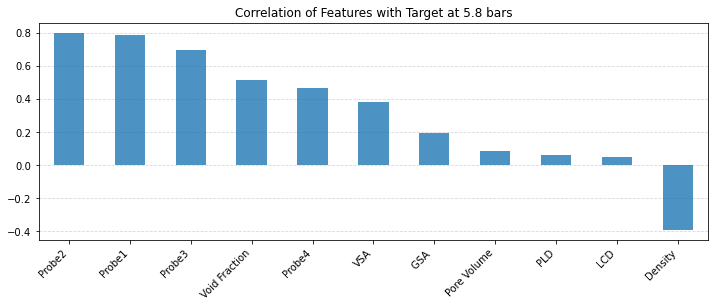

In [13]:
(data.drop('Target', axis=1)  
   .corrwith(data['Target'])
   .sort_values(ascending=False) 
   .plot(kind='bar',  
         figsize=(12, 4),  
         title="Correlation of Features with Target at 5.8 bars",  
         alpha=0.8, 
         zorder=3)  
)

plt.grid(axis='y', linestyle='--', alpha=.5)
plt.xticks(rotation=45, ha='right')
plt.show()

# Model Training

Using a Lasso Regressor.

In [14]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

lr = Lasso(alpha=0.1)
lr.fit(X_train, y_train)
y_val_pred = lr.predict(X_val)
y_test_pred = lr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

Validation Set Mean Absolute Error: 0.43382163046340844
Validation Set Mean Squared Error: 0.3511291155963634
Validation Set R-squared Score: 0.6574776453077786

Test Set Mean Absolute Error: 0.4438762887862441
Test Set Mean Squared Error: 0.46396192981027295
Test Set R-squared Score: 0.5419927651703791


Using a Support Vector Regressor.

In [15]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)
y_val_pred = svr.predict(X_val)
y_test_pred = svr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

/Users/avani/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Validation Set Mean Absolute Error: 0.19753574365688642
Validation Set Mean Squared Error: 0.0896115144048303
Validation Set R-squared Score: 0.9125850134377285

Test Set Mean Absolute Error: 0.19740118665486664
Test Set Mean Squared Error: 0.09534169141906779
Test Set R-squared Score: 0.9058819665038401


Using a Decision Tree Regressor.

In [16]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

dtr = DecisionTreeRegressor(random_state=14)
dtr.fit(X_train, y_train)
y_val_pred = dtr.predict(X_val)
y_test_pred = dtr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

Validation Set Mean Absolute Error: 0.23655555465165404
Validation Set Mean Squared Error: 0.13204631377204804
Validation Set R-squared Score: 0.8711903618564572

Test Set Mean Absolute Error: 0.24253903059586013
Test Set Mean Squared Error: 0.13394969445924446
Test Set R-squared Score: 0.8677694758476437


Using a Random Forest Regressor.

In [17]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=14)
rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_val)
y_test_pred = rfr.predict(X_test)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Validation Set Mean Absolute Error:", val_mae)
print("Validation Set Mean Squared Error:", val_mse)
print("Validation Set R-squared Score:", val_r2)

print("\nTest Set Mean Absolute Error:", test_mae)
print("Test Set Mean Squared Error:", test_mse)
print("Test Set R-squared Score:", test_r2)

<ipython-input-17-c830a43409a7>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Validation Set Mean Absolute Error: 0.16848315335494002
Validation Set Mean Squared Error: 0.06108677106400704
Validation Set R-squared Score: 0.9414653079768779

Test Set Mean Absolute Error: 0.16801834147047415
Test Set Mean Squared Error: 0.06237771927793923
Test Set R-squared Score: 0.9384228642786486


# Model Comparison

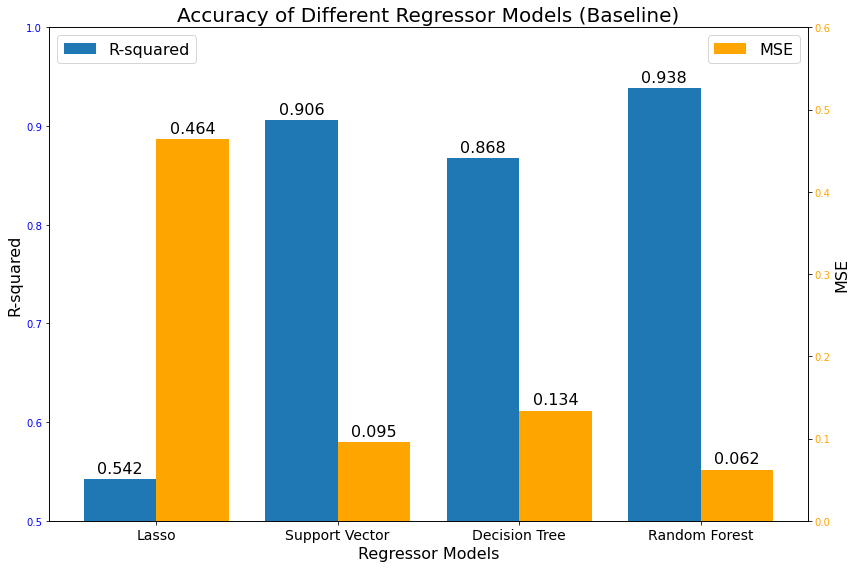

In [19]:
models = ['Lasso', 'Support Vector', 'Decision Tree', 'Random Forest']
r_squared = [0.5419927651703791, 0.9058819665038401, 0.8677694758476437, 0.9384228642786486]
MSE = [0.46396192981027295, 0.09534169141906779, 0.13394969445924446, 0.06237771927793923]

x = np.arange(len(models)) 
width = 0.4  
fig, ax1 = plt.subplots(figsize=(12, 8))

rects1 = ax1.bar(x - width/2, r_squared, width, label='R-squared')
ax1.set_ylabel('R-squared', fontsize=16)
ax1.set_ylim(0.5, 1)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Regressor Models', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=14)
ax1.set_title('Accuracy of Different Regressor Models (Baseline)', fontsize=20)
ax1.legend(loc='upper left', fontsize=16)

ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, MSE, width, label='MSE', color='orange')
ax2.set_ylabel('MSE', fontsize=16)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 0.6)
ax2.legend(loc='upper right', fontsize=16)

def add_labels(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16)

add_labels(rects1, ax1)
add_labels(rects2, ax2)

fig.tight_layout()

plt.show()

# Hyperparameter Tuning

Baseline model gives an accuracy of 93.84%. <br>
Let's perform hyperparameter tuning using GridSearchCV( ) to try and increase it.

In [12]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=14)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='r2', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
test_score = best_estimator.score(X_test, y_test)
print("Best Estimator:", grid_search.best_params_)
print("Test R-squared Score:", best_estimator.score(X_test, y_test))

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/Users/avani/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Estimator: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R-squared Score: 0.9391405782028447


In [20]:
X = data.drop(['Target'], axis=1)
y = data[['Target']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=14)
rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_val)
y_test_pred = rfr.predict(X_test)

print("Validation Set Mean Absolute Error:", mean_absolute_error(y_val, y_val_pred))
print("Validation Set Mean Squared Error:", mean_squared_error(y_val, y_val_pred))
print("Validation Set R-squared Score:", r2_score(y_val, y_val_pred))
print()
print("Test Set Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Test Set Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("Test Set R-squared Score:", r2_score(y_test, y_test_pred))

<ipython-input-20-ac20815cb00f>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Validation Set Mean Absolute Error: 0.16845043572678556
Validation Set Mean Squared Error: 0.060994896440733776
Validation Set R-squared Score: 0.9415533442682773

Test Set Mean Absolute Error: 0.16721614453573908
Test Set Mean Squared Error: 0.06165067413105291
Test Set R-squared Score: 0.9391405782028447


As the accuracy went up from 93.84% to 93.91%, hyperparameter tuning **did yield a better result** than the baseline model.

# Post Training Model Analysis

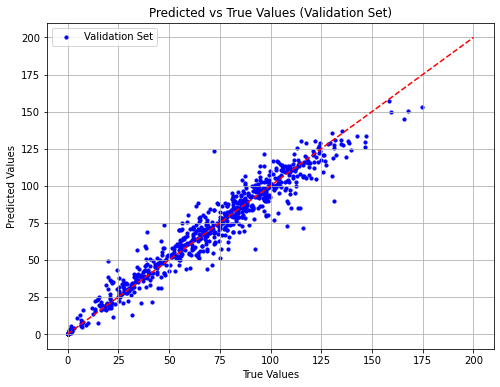

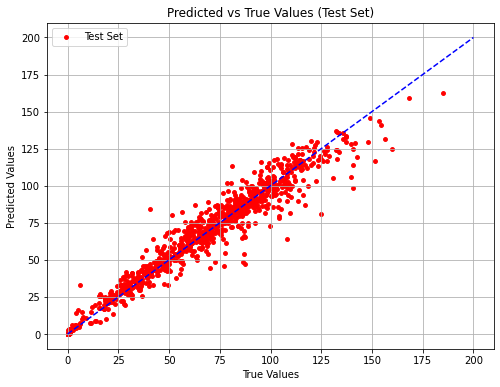

In [21]:
y_val_pred_inv = scaler_y.inverse_transform(y_val_pred)
y_val_inv = scaler_y.inverse_transform(y_val)

y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_val_inv, y_val_pred_inv, color='blue', label='Validation Set', s=10)
plt.plot([0, 200], [0, 200], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_test_pred_inv, color='red', label='Test Set', s=15)
plt.plot([0, 200], [0, 200], color='blue', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-22-5f02ca56399b>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


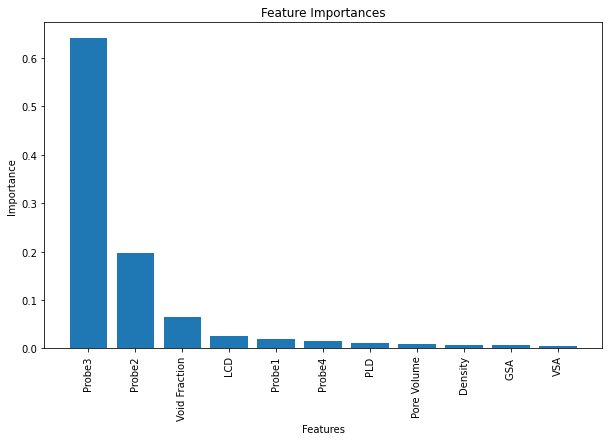

In [22]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rfr = RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=14)

rfr.fit(X_train, y_train)

importances = rfr.feature_importances_

feature_names = X.columns  

sorted_indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], tick_label=feature_names[sorted_indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [23]:
importances = rfr.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1]
for feature, importance in zip(feature_names[sorted_indices], importances[sorted_indices]):
    print(f"{feature}: {importance:.3f}")

Probe3: 0.642
Probe2: 0.197
Void Fraction: 0.065
LCD: 0.026
Probe1: 0.019
Probe4: 0.014
PLD: 0.011
Pore Volume: 0.009
Density: 0.007
GSA : 0.006
VSA: 0.005
